In [18]:
# Step 1: Import Libraries and Load Dataset
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, SMOTENC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap

# Load dataset
#data = pd.read_csv("loan_data.csv")
data = pd.read_csv("/kaggle/input/load-data/loan_data.csv")
data

,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2072-09-29,44,30180,587,Employed,High School,19,24521,36,Married,...,2515.000000,0.826217,1,55327,0.216021,0.195574,905.767712,0.627741,0,55.0
19996,2072-09-30,56,49246,567,Employed,Associate,33,25818,36,Married,...,4103.833333,0.816618,3,64002,0.227318,0.199168,958.395633,0.334418,0,54.0
19997,2072-10-01,44,48958,645,Employed,Bachelor,20,37033,72,Married,...,4079.833333,0.887216,3,103663,0.229533,0.226766,945.427454,0.357227,0,45.0
19998,2072-10-02,60,41025,560,Employed,High School,36,14760,72,Married,...,3418.750000,0.843787,5,10600,0.249760,0.264873,411.168284,0.408678,0,59.0


In [27]:
# Step 2: Data Preprocessing
# Check for missing values
# Separate numerical and categorical columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

# 1.1 Handle missing values for numerical columns
print('Missing data for numerical field:',numerical_cols.isnull().sum())
data[numerical_cols] = data[numerical_cols].apply(lambda col: col.fillna(col.median()))

# 1.2 Handle missing values for categorical columns
print('Missing data for categorical field:',categorical_cols.isnull().sum())
data[categorical_cols] = data[categorical_cols].apply(lambda col: col.fillna(col.mode()[0]))

# 2.1 Remove outliers in numerical columns using the IQR method
target = 'LoanApproved'
for col in numerical_cols:
    if (col != target):
        #print (col)
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
            
            # Filter out outliers
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

# 2.2 Handle rare categories in categorical columns by grouping them into an "Other" category
for col in categorical_cols:
    if (col != target):
        freq_counts = data[col].value_counts(normalize=True)
        rare_categories = freq_counts[freq_counts < 0.01].index  # Categories with < 1% frequency
        data[col] = data[col].apply(lambda x: 'Other' if x in rare_categories else x)

# 3.1 Handle Imbalanced Classes for numerical field
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Define features and target
X = data.drop('LoanApproved', axis=1)  # Replace 'fraudulent' with the actual target column
y = data['LoanApproved']

X_numerical = data[numerical_cols]
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=0.3, random_state=42)

# Apply SMOTE to handle imbalanced classes in the training data
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# 3.2 Handle Imbalanced Classes for categorical field
# Split the combined data into training and testing sets
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(X, y, test_size=0.3, random_state=42)

# Identify indices of categorical columns for SMOTENC
categorical_indices = [X.columns.get_loc(col) for col in categorical_cols]

# Apply SMOTENC to the combined data
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_resampled_comb, y_resampled_comb = smote_nc.fit_resample(X_train_comb, y_train_comb)


Missing data for numerical field: 0
Missing data for categorical field: 0


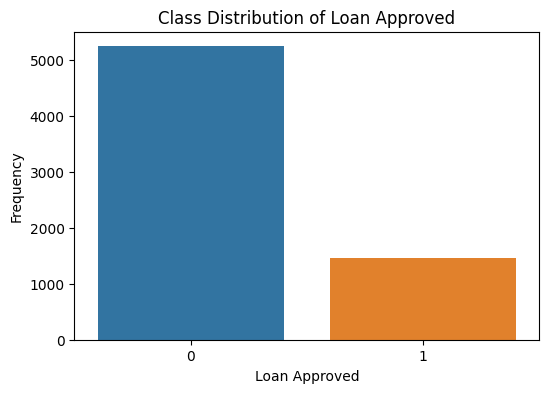

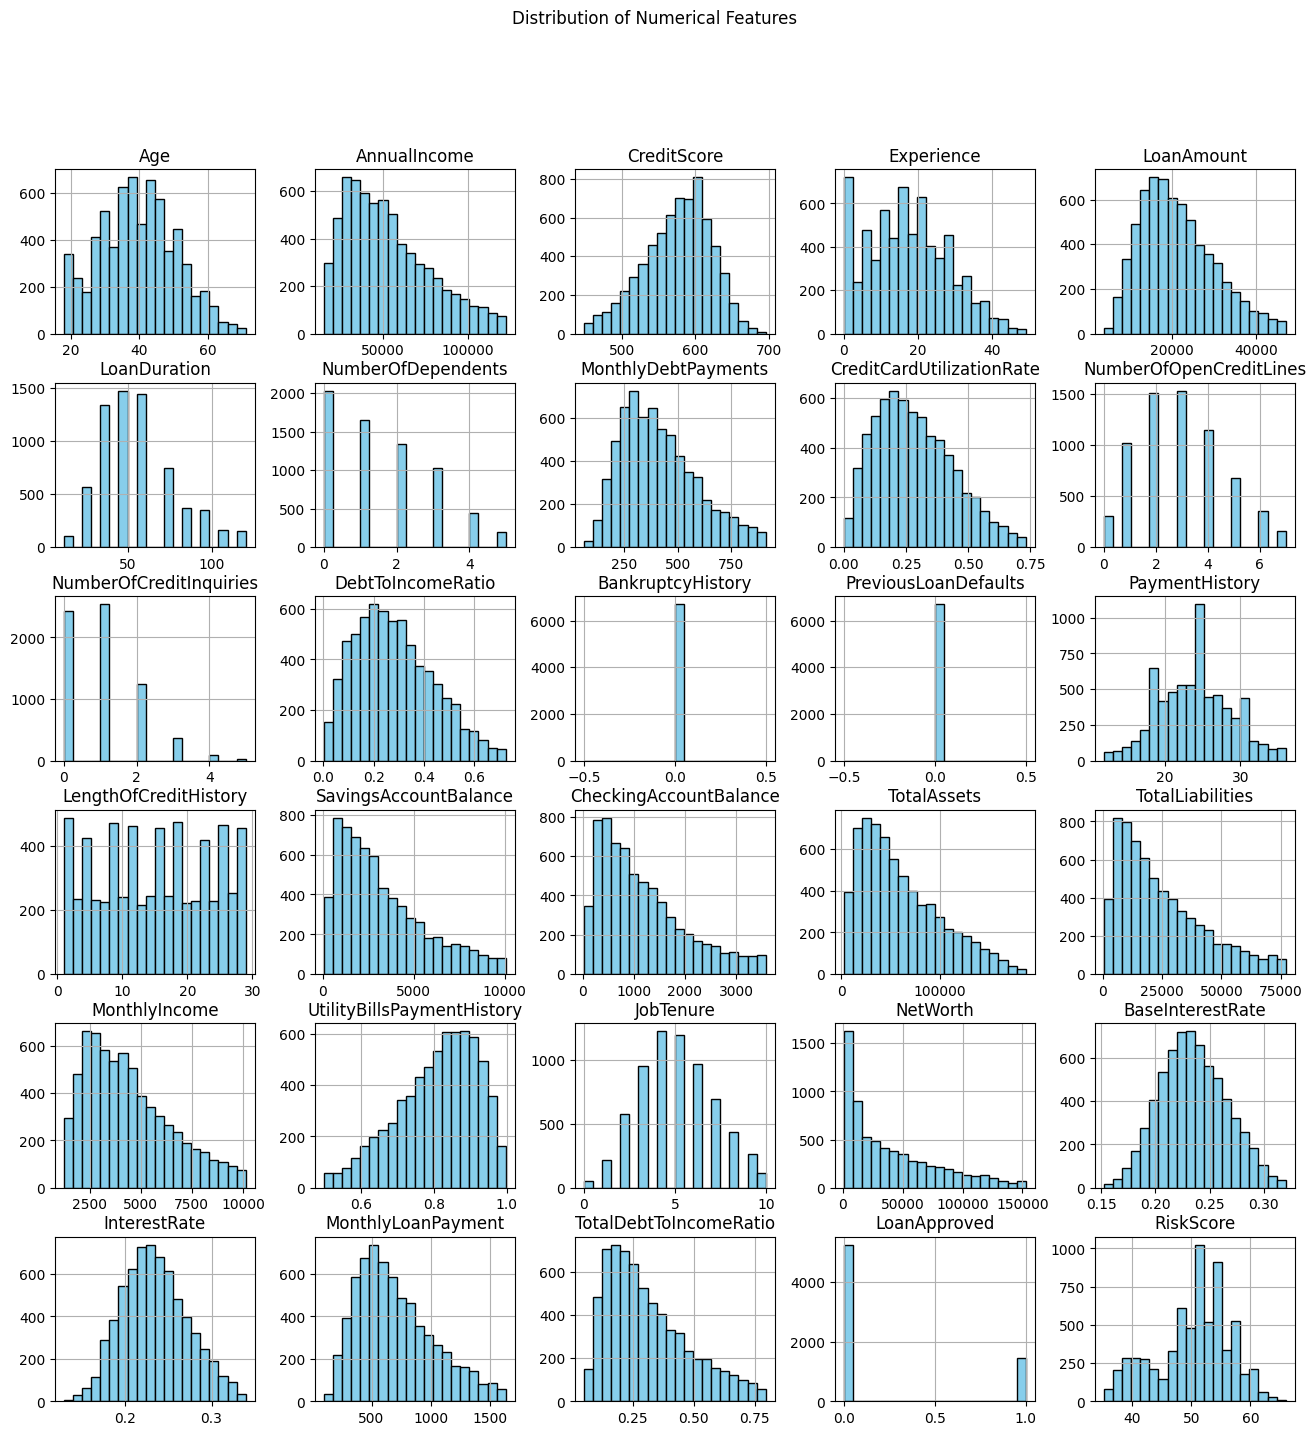

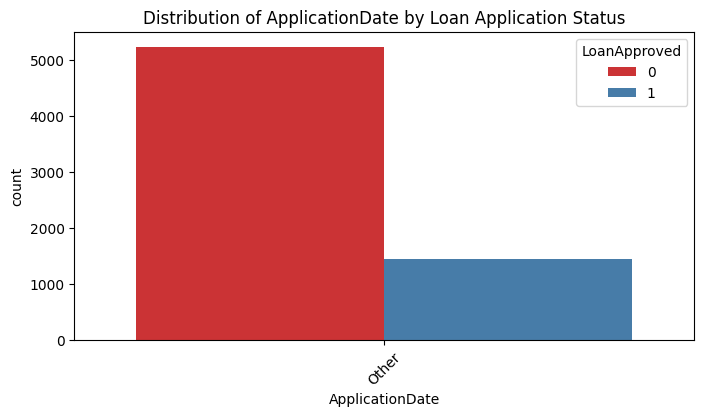

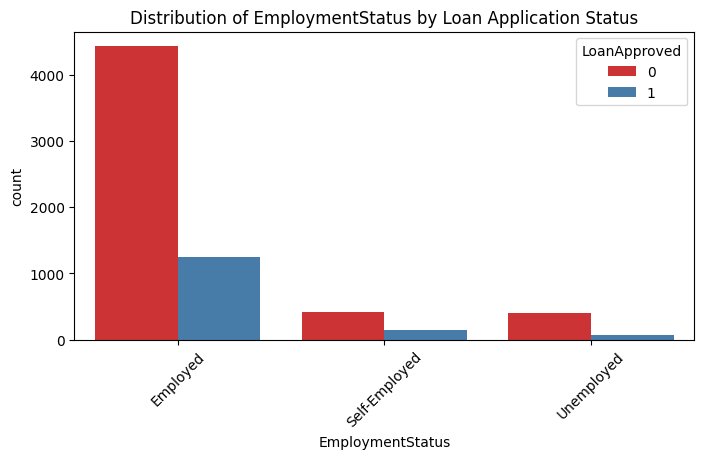

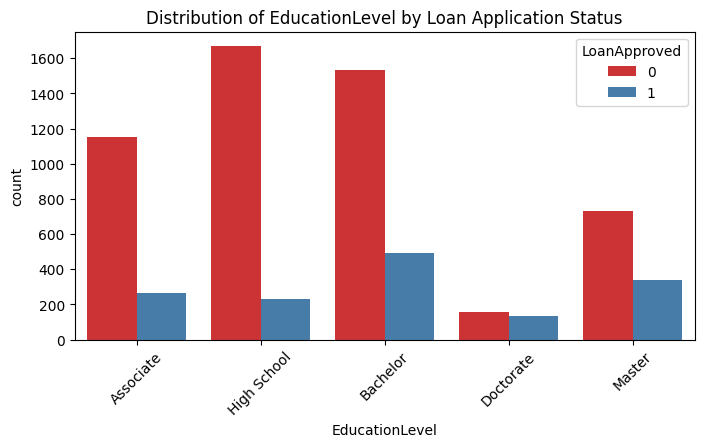

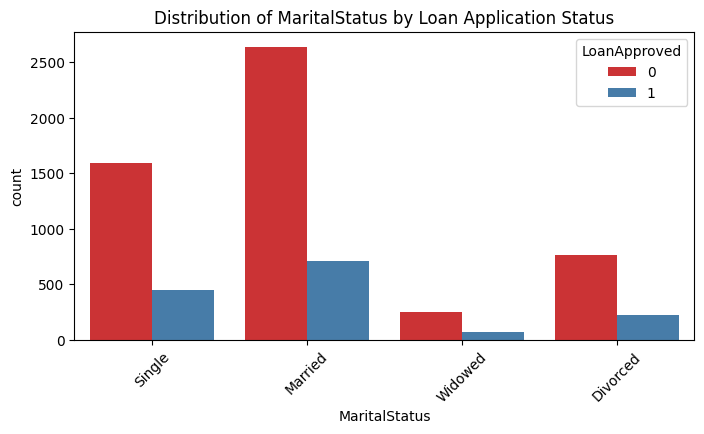

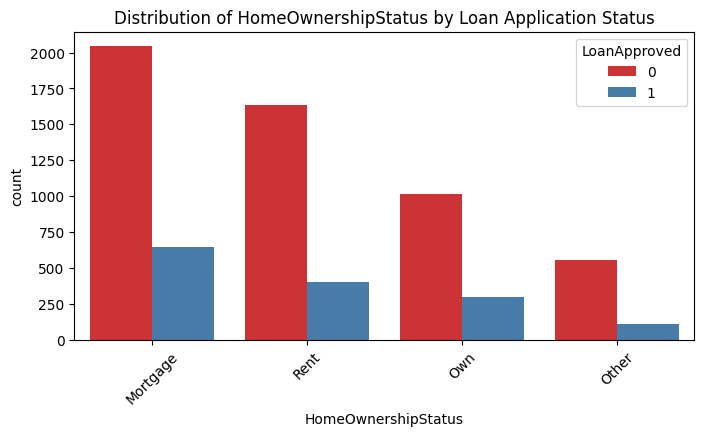

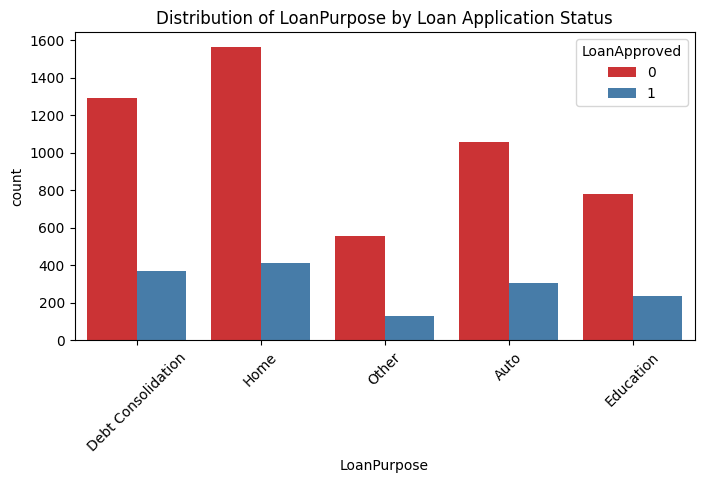

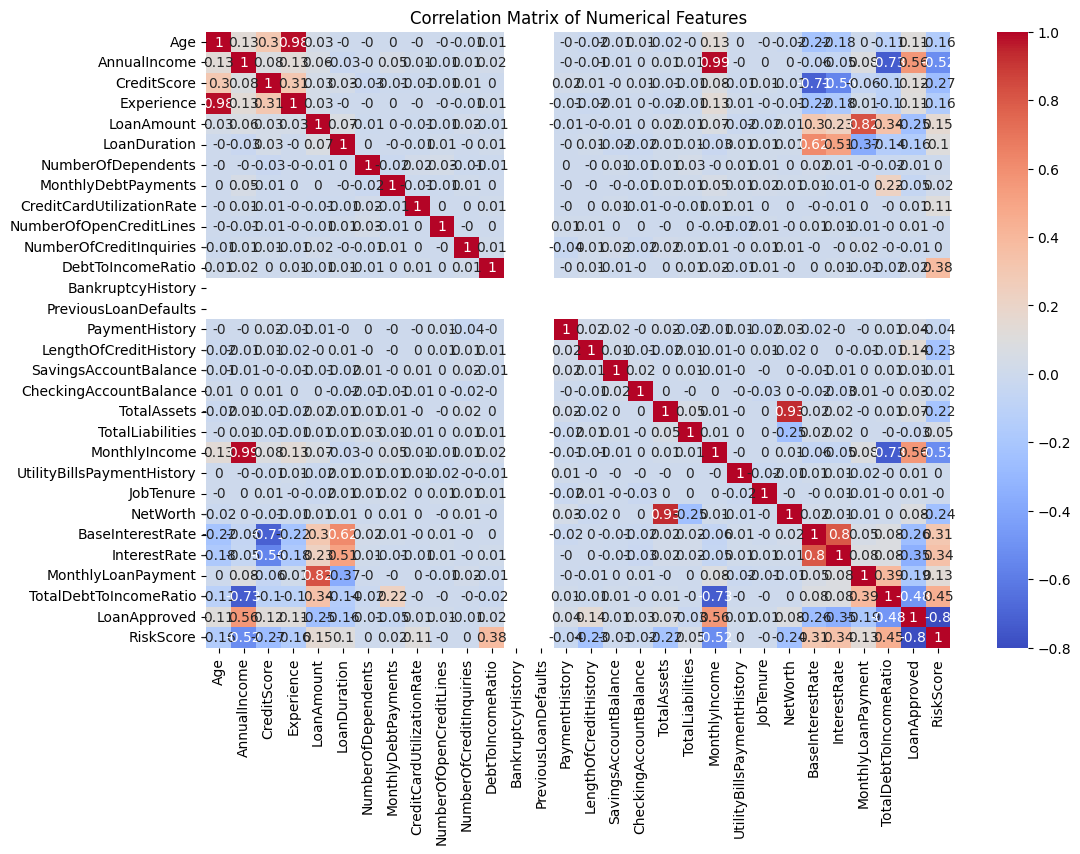

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
use_inf_as_na op

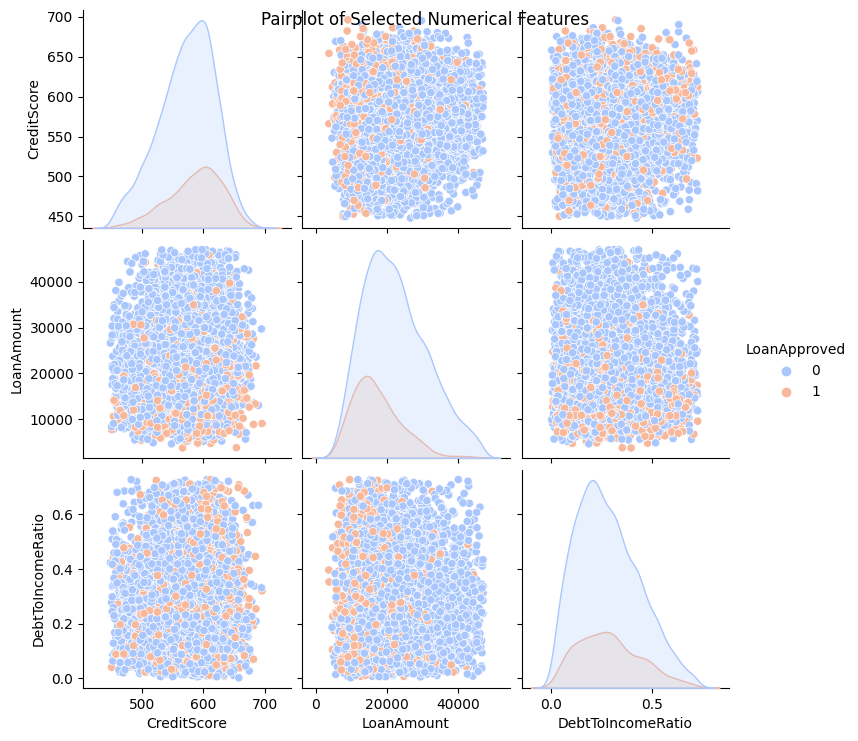

In [28]:
# Step 3: Exploratory Data Analysis (EDA)
# Plotting the distribution of the target variable
# 1. Class Distribution of Target Variable (Loan Approved)
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='LoanApproved')
plt.title('Class Distribution of Loan Approved')
plt.xlabel('Loan Approved')
plt.ylabel('Frequency')
plt.show()

# 2. Distribution of Numerical Features
data[numerical_cols].hist(bins=20, figsize=(16, 16), color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Numerical Features")
plt.show()

# 3. Distribution of Categorical Features
# Bar plots for each categorical feature
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data, x=col, hue=target, palette="Set1")
    plt.title(f"Distribution of {col} by Loan Application Status")
    plt.xticks(rotation=45)
    plt.show()

# 4. Correlation Matrix for Numerical Features (with 3 decimal points)
# Compute the correlation matrix and round to 3 decimal points
correlation_matrix = data[numerical_cols].corr().round(2)
# Plotting the heatmap with 2 decimal places
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# 5. Pairplot for Selected Highly Correlated Numerical Features with Target
# Selecting a few features that might be highly correlated with Loan Approved for pairplot
selected_features = ['CreditScore', 'LoanAmount', 'DebtToIncomeRatio', 'LoanApproved']
sns.pairplot(data[selected_features], hue='LoanApproved', palette='coolwarm')
plt.suptitle("Pairplot of Selected Numerical Features")
plt.show()


In [29]:
# Step 4: Feature Engineering

# 1. Income per Dependent to highlight financial burden
data['Income_per_Dependent'] = data['AnnualIncome'] / (data['NumberOfDependents'] + 1)

# 2. Loan-to-Asset Ratio - high loan-to-asset ratio might indicate increased fraud risk
if 'TotalAssets' in data.columns:
    data['Loan_to_Asset_Ratio'] = data['LoanAmount'] / (data['TotalAssets'] + 1e-5)

# 3. High Loan Amount Flag to set a certain threshold
data['High_Loan_Amount'] = (data['LoanAmount'] > data['LoanAmount'].mean()).astype(int)

# 4. Family Size 
# Update 'MaritalStatus' column based on the mapping
if 'MaritalStatus' in data.columns:
    #print (data['MaritalStatus'])
    if data['MaritalStatus'].dtype == 'object': 
        data['MaritalStatus'] = data['MaritalStatus'].map({'Married': 1, 'Single': 0, 'Widowed': 0, 'Divorced': 0})
        #print (data['MaritalStatus'])
    
# Calculate Family Size (assuming Married is now a binary column: 1 if married, 0 otherwise)
if 'MaritalStatus' in data.columns and 'NumberOfDependents' in data.columns:
    data['Family_Size'] = data['MaritalStatus'] + data['NumberOfDependents']

# Prepare data for model training
# Separate features and target variable
target_column = 'LoanApproved'  
X = data.drop(columns=[target_column])
y = data[target_column]

# Convert categorical features to numerical
X = pd.get_dummies(X, drop_first=True)
#print (X)
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a model to evaluate feature impact (using a basic Random Forest model)
modelrf = RandomForestClassifier(random_state=42)
modelrf.fit(X_train, y_train)

# Predictions
y_pred = modelrf.predict(X_test)

# Evaluate model performance
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Model Performance with New Features")

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Confusion Matrix: \n{conf_matrix}")

# Feature Importance Analysis
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': modelrf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:\n", feature_importances)

Model Performance with New Features
Precision: 0.98
Recall: 0.94
F1 Score: 0.96
Confusion Matrix: 
[[1553    7]
 [  26  425]]

Feature Importances:
                            Feature  Importance
29                       RiskScore    0.477132
28          TotalDebtToIncomeRatio    0.097082
21                   MonthlyIncome    0.075453
1                     AnnualIncome    0.070772
26                    InterestRate    0.052533
30            Income_per_Dependent    0.026026
4                       LoanAmount    0.020415
25                BaseInterestRate    0.015424
31             Loan_to_Asset_Ratio    0.013106
5                     LoanDuration    0.011330
16           LengthOfCreditHistory    0.011109
27              MonthlyLoanPayment    0.010429
12               DebtToIncomeRatio    0.009975
2                      CreditScore    0.009604
24                        NetWorth    0.008126
8              MonthlyDebtPayments    0.007582
19                     TotalAssets    0.007350
18   

In [30]:
# Step 5: Model Building
# Model building using XGBoost 
# Calculate scale_pos_weight for XGBoost based on class imbalance
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to handle class imbalance for XGBoost
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Calculate scale_pos_weight for XGBoost based on class imbalance
positive_class = y_train_smote.sum()  # Number of positive class instances
negative_class = len(y_train_smote) - positive_class  # Number of negative class instances
scale_pos_weight = negative_class / positive_class

# Train the XGBoost model with scale_pos_weight
model_xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
model_xgb.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate the model
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Confusion Matrix: \n{conf_matrix}")

# Cross-validation on training data
cv_scores = cross_val_score(model_xgb, X_train_smote, y_train_smote, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.2f}")


Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Confusion Matrix: 
[[1558    2]
 [   2  449]]
Cross-validation accuracy: 1.00


In [31]:
# Model buidling using LightGBM 
# Apply class weights to handle class imbalance for LightGBM
model_lgb = LGBMClassifier(class_weight='balanced',verbose=-1,random_state=42)  # Automatically handles imbalance
#model_lgb = lgb.LGBMClassifier(random_state=42)

# Fit the model
model_lgb.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred_lgb = model_lgb.predict(X_test)

# Calculate Precision, Recall, F1-Score, and Confusion Matrix
precision = precision_score(y_test, y_pred_lgb)
recall = recall_score(y_test, y_pred_lgb)
f1 = f1_score(y_test, y_pred_lgb)
conf_matrix = confusion_matrix(y_test, y_pred_lgb)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Confusion Matrix: \n{conf_matrix}")

# Cross-validation on training data
cv_scores = cross_val_score(model_lgb, X_train_smote, y_train_smote, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.2f}")

Precision: 1.00
Recall: 0.99
F1 Score: 0.99
Confusion Matrix: 
[[1558    2]
 [   3  448]]
Cross-validation accuracy: 1.00


In [32]:
# Random Forest with hyperparameter tuning
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Set up parameter grid for cross-validation
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search with cross-validation
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Best parameters and model evaluation
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Random Forest Results:")
print("Best Parameters:", grid_search_rf.best_params_)
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Results:
Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Precision: 0.9797297297297297
Recall: 0.9645232815964523
F1 Score: 0.9720670391061451
Confusion Matrix:
 [[1551    9]
 [  16  435]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1560
           1       0.98      0.96      0.97       451

    accuracy                           0.99      2011
   macro avg       0.98      0.98      0.98      2011
weighted avg       0.99      0.99      0.99      2011



In [33]:
# XGBoost with hyperparameter tuning
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Set up parameter grid for cross-validation

param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0]
}

# Perform grid search with cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring='f1', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Best parameters and model evaluation
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print("XGBoost Results:")
print("Best Parameters:", grid_search_xgb.best_params_)
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Results:
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Precision: 0.9977678571428571
Recall: 0.991130820399113
F1 Score: 0.9944382647385984
Confusion Matrix:
 [[1559    1]
 [   4  447]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1560
           1       1.00      0.99      0.99       451

    accuracy                           1.00      2011
   macro avg       1.00      1.00      1.00      2011
weighted avg       1.00      1.00      1.00      2011



In [34]:
# LightGBM with hyperparameter tuning

import warnings
warnings.filterwarnings("ignore")  # This will ignore all warnings

from lightgbm import LGBMClassifier

# Initialize LightGBM with verbose parameter set to -1
lgbm_model = LGBMClassifier(verbose=-1)

#lgbm_model = LGBMClassifier(random_state=42)

# Set up parameter grid for cross-validation
param_grid_lgbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50],
    'max_depth': [3, 5, 7]
}

# Perform grid search with cross-validation
grid_search_lgbm = GridSearchCV(estimator=lgbm_model, param_grid=param_grid_lgbm, cv=5, scoring='f1', n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# Best parameters and model evaluation
best_lgbm = grid_search_lgbm.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_test)

print("LightGBM Results:")
print("Best Parameters:", grid_search_lgbm.best_params_)
print("Precision:", precision_score(y_test, y_pred_lgbm))
print("Recall:", recall_score(y_test, y_pred_lgbm))
print("F1 Score:", f1_score(y_test, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))


LightGBM Results:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 31}
Precision: 1.0
Recall: 0.9955654101995566
F1 Score: 0.9977777777777778
Confusion Matrix:
 [[1560    0]
 [   2  449]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1560
           1       1.00      1.00      1.00       451

    accuracy                           1.00      2011
   macro avg       1.00      1.00      1.00      2011
weighted avg       1.00      1.00      1.00      2011



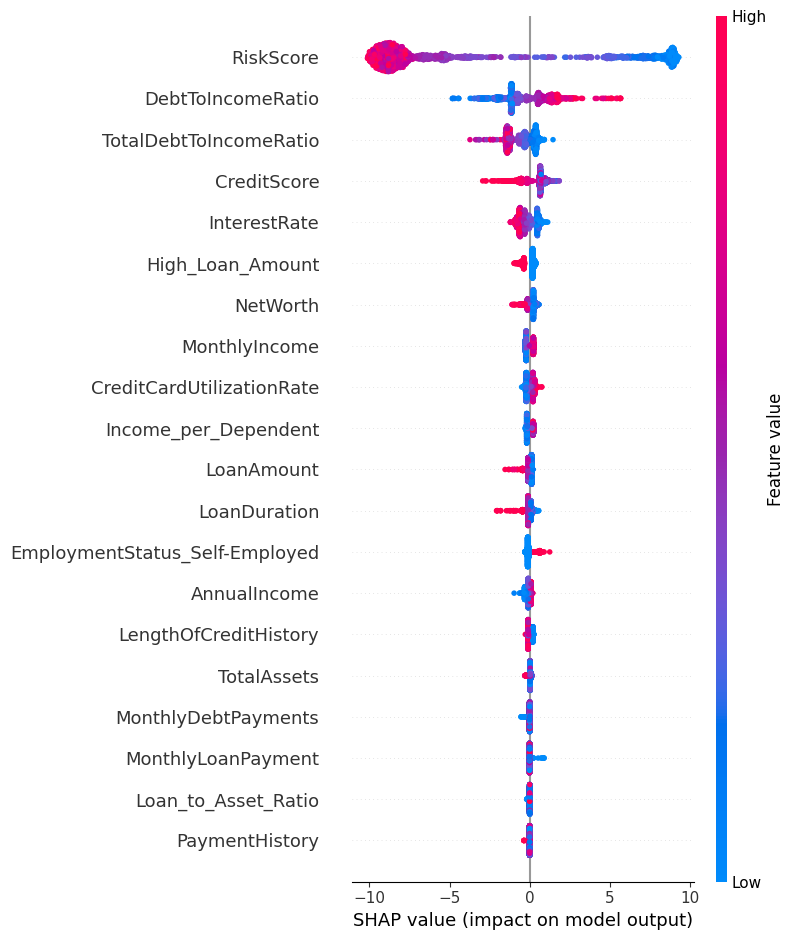

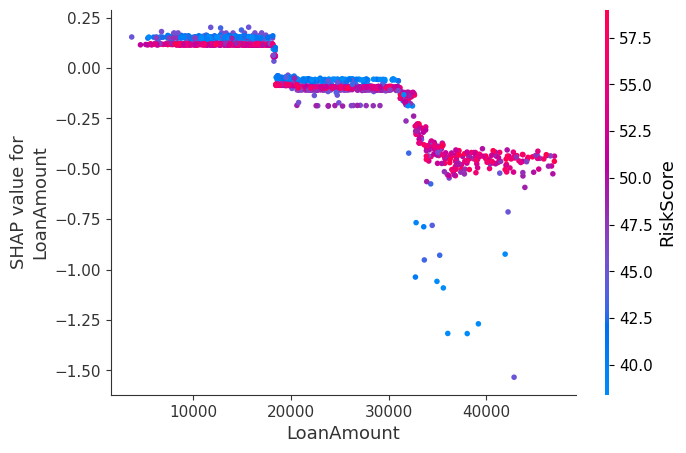

                      feature  importance
29                  RiskScore    7.904562
12          DebtToIncomeRatio    1.245021
28     TotalDebtToIncomeRatio    0.740743
2                 CreditScore    0.698102
26               InterestRate    0.471494
32           High_Loan_Amount    0.325373
24                   NetWorth    0.259566
21              MonthlyIncome    0.213667
9   CreditCardUtilizationRate    0.205088
30       Income_per_Dependent    0.169837


In [35]:
# Step 6: Model Interpretability:
# Create the SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(model_xgb)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Dependence plot for a specific feature, e.g., "LoanAmount"
shap.dependence_plot("LoanAmount", shap_values, X_test)


# Create a DataFrame to store feature importance
shap_importance = pd.DataFrame({
    "feature": X_test.columns,
    "importance": np.abs(shap_values).mean(axis=0)
})
shap_importance = shap_importance.sort_values(by="importance", ascending=False)
print(shap_importance.head(10))  # Display top 10 most important features


Misclassified samples:
        Age  AnnualIncome  CreditScore  Experience  LoanAmount  LoanDuration  \
8844    45         69206          585          21       27698            36   
15178   35         48457          592          12        9258            36   
3048    45         44180          584          22       19705            48   
18092   34         83805          622          11       19627           120   
4755    43         56685          503          18        8060            24   

       MaritalStatus  NumberOfDependents  MonthlyDebtPayments  \
8844               1                   0                  385   
15178              0                   0                  452   
3048               0                   1                  382   
18092              1                   3                  364   
4755               1                   3                  640   

       CreditCardUtilizationRate  ...  HomeOwnershipStatus_Other  \
8844                    0.496325  ...     

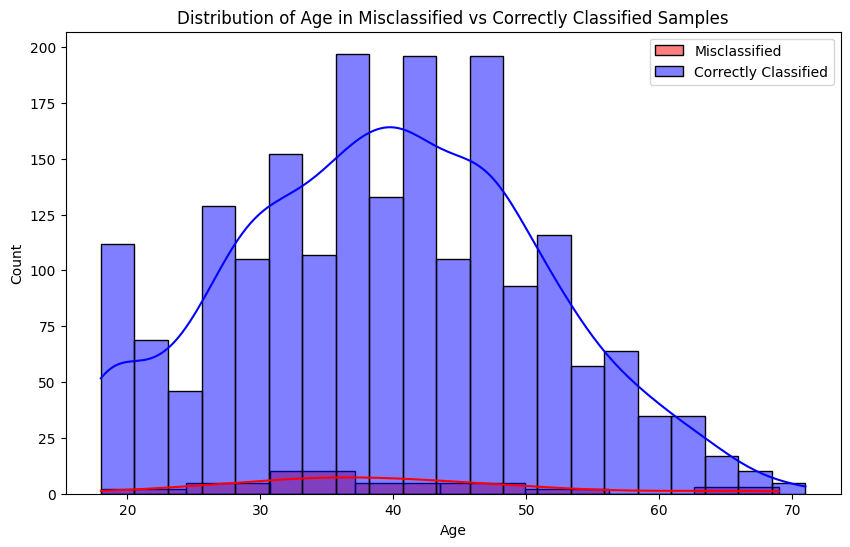

In [36]:
# Step 7: Model Performance and Error Analysis
# Predict probabilities for both classes
modelrf = RandomForestClassifier(random_state=42)
modelrf.fit(X_train, y_train)

y_pred_probs = modelrf.predict_proba(X_test)[:, 1]
y_pred = modelrf.predict(X_test)

# Create a DataFrame to analyze errors
error_analysis_df = X_test.copy()
error_analysis_df['Actual'] = y_test
error_analysis_df['Predicted'] = y_pred
error_analysis_df['Pred_Prob'] = y_pred_probs

# Identify Misclassified Instances
# Filter to find misclassified samples
misclassified_df = error_analysis_df[error_analysis_df['Actual'] != error_analysis_df['Predicted']]
print("Misclassified samples:\n", misclassified_df.head())

# Error Pattern Analysis
# 1. Confidence of Predictions:
# Find misclassifications with low confidence (e.g., probability close to 0.5)
uncertain_misclassified = misclassified_df[(misclassified_df['Pred_Prob'] > 0.4) & (misclassified_df['Pred_Prob'] < 0.6)]
print("Low Confidence Misclassifications:\n", uncertain_misclassified)

# 2. Feature Analysis in Misclassifications:

# Example: Analyze a specific feature in misclassified vs correctly classified samples
feature = 'Age'  # Example feature
plt.figure(figsize=(10, 6))
sns.histplot(misclassified_df[feature], color='red', label='Misclassified', kde=True)
sns.histplot(error_analysis_df[error_analysis_df['Actual'] == error_analysis_df['Predicted']][feature], color='blue', label='Correctly Classified', kde=True)
plt.legend()
plt.title(f"Distribution of {feature} in Misclassified vs Correctly Classified Samples")
plt.show()



In [37]:
# Cross-Validation and Threshold Adjustment


from sklearn.metrics import precision_recall_curve

# Adjusting the threshold based on precision-recall trade-offs
y_pred_probs = modelrf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Select a threshold to balance precision and recall (e.g., maximizing F1 score)
optimal_threshold = thresholds[(precision + recall).argmax()]
print("Optimal Threshold:", optimal_threshold)

# Apply the threshold to adjust predictions
y_pred_adjusted = (y_pred_probs >= optimal_threshold).astype(int)
print("Adjusted F1 Score:", f1_score(y_test, y_pred_adjusted))


Optimal Threshold: 0.37
Adjusted F1 Score: 0.9746416758544654


In [38]:
# Save models using joblib
import joblib
from joblib import dump, load


# Assuming `rf_model`, `xgb_model`, and `lgbm_model` are your trained models
# Random Forest
dump(modelrf, 'modelrf.joblib')

# XGBoost
dump(model_xgb, 'model_xgb.joblib')

# LightGBM
dump(model_lgb, 'model_lgb.joblib')


['model_lgb.joblib']